# GNSS Review

In [1]:
from logparser import LogReader
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, BoxZoomTool
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook, export_png
import pandas as pd
import numpy as np
import pymap3d as pm

from bokehPlots import plotLineTimeRange, plotHist, plotEN_pyplot, plot_hist_pyplot

output_notebook()

Loading BokehJS ...

In [2]:
#filepath = "./.data/log_mimir_20230715122058.txt"

filepath = "./.data/gnss_log_2023_04_14_15_23_32.txt"
time_range = ('2023-04-14 12:23:30','2023-04-14 12:30:00')

deviceName = "Google Pixel 7"
filepath = "./.data/gnss_log_2023_03_03_10_29_45.txt"
time_range = ('2023-03-03 08:29:47.000','2023-03-03 08:33:00.000')

deviceName = "Xiaomi 11"
filepath = "./.data/gnss_log_2023_03_03_09_56_06.txt"
time_range = ('2023-03-03 07:56:12.000','2023-03-03 08:41:11.000')

log = LogReader(filepath, ['Raw', 'Fix'])

#log.fix


## Pseudorange Analysis

In [3]:
# Turn to time serie
ts = log.raw.set_index('datetime')

data_name = 'PseudorangeAcceleration'

sats = list(set(ts["prn"]))
sats.sort()
sats = [item for item in sats if item.startswith('E')]
# sats = ['G02-L1']

_ts = ts.loc[ts['prn'].isin(sats), [data_name, 'prn']]

# Filter
# _ts[data_name] = _ts[data_name].abs()
# q = _ts[data_name].quantile(0.99)
# _ts = _ts[ts[data_name] < q] 

p = plotHist(_ts, 'PseudorangeAcceleration')

show(p)

#save(p, filename="pseudo_error_Galileo.html")

#export_png(p, filename="pseudo_error_Galileo.png")


# Position analysis

In [4]:
def convert2ENU(lat, lon, alt, ref):
    east, north, up = pm.geodetic2enu(lat, lon, alt, ref[0], ref[1], ref[2])
    return {"east":east, "north":north, "up":up}

def getHorizontalError(north, east):
    error = np.sqrt(north**2 + east**2)
    return {"2D_error":error}

In [12]:

pos = log.fix.loc[log.fix['provider'].isin(['GPS']), ['datetime', 'latitude', 'longitude', 'altitude']]
pos = pos.set_index('datetime')

pos = pos.loc[time_range[0]:time_range[1]]

ref_enu = [pos['latitude'].mean(), pos['longitude'].mean(), pos['altitude'].mean()]

pos[["east", "north", "up"]] = pos.apply(
    lambda row: convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
    axis='columns', result_type='expand')

#plotEN_pyplot(pos, 0.5)

pos 

,latitude,longitude,altitude,east,north,up
datetime,,,,,,
2023-03-03 07:56:12,61.449192,23.856315,160.3,-0.007247,1.478025,1.392140
2023-03-03 07:56:14,61.449192,23.856315,160.3,-0.007247,1.478025,1.392140
2023-03-03 07:56:17,61.449193,23.856328,160.2,0.703992,1.663750,1.292139
2023-03-03 07:56:18,61.449193,23.856328,160.2,0.703992,1.663750,1.292139
2023-03-03 07:56:24,61.449185,23.856335,159.6,1.059615,0.735093,0.692140
...,...,...,...,...,...,...
2023-03-03 08:41:03,61.449178,23.856315,158.9,-0.007247,-0.007840,-0.007860
2023-03-03 08:41:07,61.449178,23.856315,158.9,-0.007247,-0.007840,-0.007860
2023-03-03 08:41:08,61.449178,23.856315,158.9,-0.007247,-0.007840,-0.007860


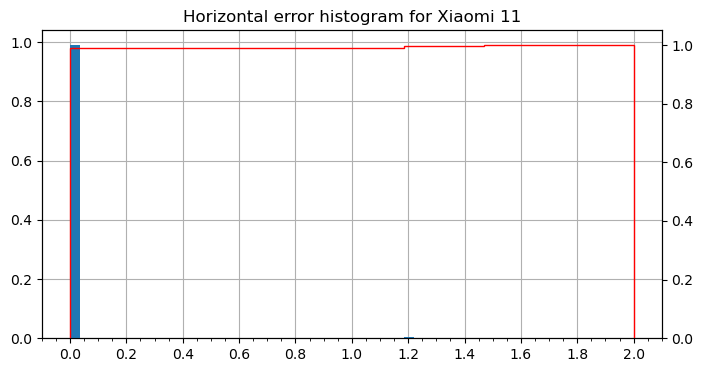

In [6]:
#plot_hist_pyplot(pos, 'east', lim=np.max(np.abs(ts[data_name])))

pos[["2D_error"]] = pos.apply(
    lambda row: getHorizontalError(row['north'], row['east']), 
    axis='columns', result_type='expand')

plot_hist_pyplot(pos, '2D_error', lim=2, title=f'Horizontal error histogram for {deviceName}')